In [5]:
#NBVAL_IGNORE_OUTPUT
# Adding ignore due to (probably an np notebook magic) bug
import numpy as np
%matplotlib inline

Operator `initdamp` ran in 0.01 s


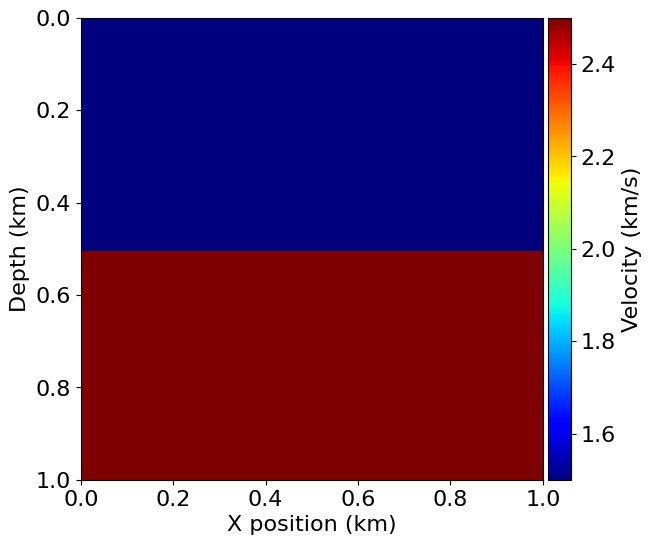

In [6]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

In [9]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

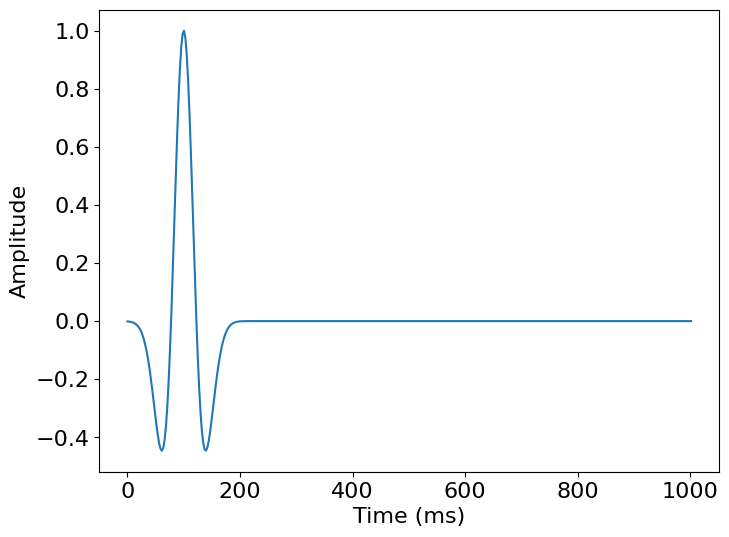

In [10]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

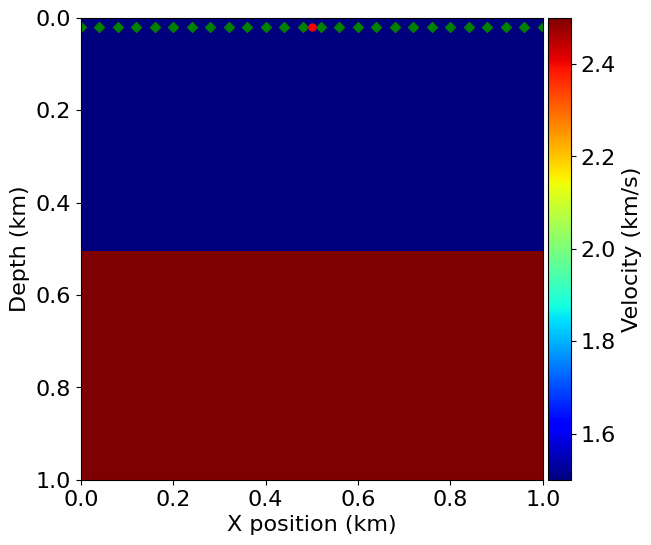

In [11]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [16]:
from devito import Function, Eq, Operator, solve, laplace
import numpy as np

# Parámetros
omega = 2 * np.pi * f0  # frecuencia angular basada en Ricker
m = model.m  # slowness squared (1/c^2)

# Solución estacionaria
u = Function(name="u", grid=model.grid)

# Definir fuente como una función puntual en el espacio
f = Function(name="f", grid=model.grid)
x, z = model.grid.dimensions

# Coordenadas de la fuente
src_x = int(src.coordinates.data[0, 0] / model.spacing[0])
src_z = int(src.coordinates.data[0, 1] / model.spacing[1])

# Usar el valor pico de la onda Ricker
t_index_max = np.argmax(np.abs(src.data[0]))
src_peak = src.data[0, t_index_max]

# Inyectar esa fuente como delta espacial
f.data[src_x, src_z] = src_peak

# Ecuación de Helmholtz: ∇²u + ω² m u = f
eq = Eq(laplace(u) + omega**2 * m * u - f)

# Resolver
stencil = solve(eq, u)
op = Operator(Eq(u, stencil), subs=model.spacing_map)
op()


Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=8.7e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])